In [1]:
import sys
print(sys.version)

3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:21:09) 
[Clang 9.0.1 ]


In [2]:
"""
Created on January 2 2021
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *

# 0.35d or greater

print('Zernike_Module.__version__: '+str(Zernike_Module.__version__))
print('Zernike_Analysis_Module.__version__: '+str(Zernike_Analysis_Module.__version__))

Zernike_Module.__version__: 0.37
Zernike_Analysis_Module.__version__: 0.26b


In [6]:
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle
import glob
import time

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

from astropy.io import fits

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c



print(np.__version__)
print(skimage.__version__)
print(scipy.__version__)
print(pd.__version__)

1.18.5
0.17.2
1.5.0
1.0.5


# Dec 30 run

In [409]:
finalHgAr_Feb2020_dataset=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes/finalHgAr_Feb2020",allow_pickle=True)

finalAr_Feb2020_dataset=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes/finalAr_Feb2020.pkl",allow_pickle=True)
finalNe_Feb2020_dataset=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes/finalNe_Feb2020",allow_pickle=True)
finalKr_Feb2020_dataset=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes/finalKr_Feb2020",allow_pickle=True)

In [410]:

#list_of_HgAr_to_analyze=finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']=='1'].index
list_of_Ar_to_analyze=finalAr_Feb2020_dataset[finalAr_Feb2020_dataset['close']=='1'].index
list_of_Ne_to_analyze=finalNe_Feb2020_dataset[finalNe_Feb2020_dataset['close']=='1'].index
list_of_Kr_to_analyze=finalKr_Feb2020_dataset[finalKr_Feb2020_dataset['close']==1].index

#print(len(list_of_HgAr_to_analyze))
print(len(list_of_Ar_to_analyze))
print(len(list_of_Ne_to_analyze))
print(len(list_of_Kr_to_analyze))

print(list_of_Ar_to_analyze)
print(list_of_Ne_to_analyze)
print(list_of_Kr_to_analyze)

def remove(string): 
    return string.replace(" ", "")

70
40
10
Int64Index([  1,   3,   5,   6,   7,   9,  11,  13,  15,  17,  18,  19,  21,
             23,  25,  27,  29,  30,  31,  33,  35,  37,  39,  41,  42,  43,
             45,  47,  49,  51,  53,  54,  55,  57,  59,  61,  63,  65,  66,
             67,  69,  71,  73,  75,  77,  78,  79,  81,  83,  85,  87,  89,
             90,  91,  93,  95,  97,  99, 101, 102, 103, 105, 107, 109, 111,
            113, 114, 115, 117, 119],
           dtype='int64')
Int64Index([ 2,  5,  6,  7, 11, 14, 15, 16, 20, 23, 24, 25, 29, 32, 33, 34, 38,
            41, 42, 43, 47, 50, 51, 52, 56, 59, 60, 61, 65, 68, 69, 70, 74, 77,
            78, 79, 83, 86, 87, 88],
           dtype='int64')
Int64Index([3, 7, 11, 15, 19, 23, 27, 31, 35, 39], dtype='int64')


In [414]:
date='Dec30'


for single_spot in list_of_Ar_to_analyze:
    if str(finalAr_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalAr_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
        double_source=True
    else:
        double_source=False    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T_Ar_1_'+str(single_spot)+date+'.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 19:55:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, m35, m3, p3, p35, p4
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py -obs 34341 34347 34353 34383 34389 34395 34425 34431 34437 -spot "+str(single_spot)+\
               " -nsteps 51 -eps 6 -dataset 6 -arc Ar -double_sources "+str(double_source)+\
               " -double_sources_positions_ratios "+remove(str(list(finalAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+\
               " -twentytwo_or_extra 56 -date_of_input Mar06 -direct_or_interpolation direct -date_of_output "+date+" -analysis_type defocus \n")
    file.close()    
  



file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/'+date+'ScriptToSubmitScriptsTiger_Ar_1_'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Ar_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T_Ar_1_'+str(single_spot)+date+'.sh \n')

file.close()

In [415]:
for single_spot in list_of_Ne_to_analyze:
    if str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
        double_source=True
    else:
        double_source=False    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T_Ne_1_'+str(single_spot)+date+'.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 19:55:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, m35, m3, m05, 0, p05, p3, p35, p4
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py -obs 34217 34223 34229 34259 34265 34271 34301 34307 34313 -spot "+str(single_spot)+\
               " -nsteps 51 -eps 6 -dataset 6 -arc Ne -double_sources "+str(double_source)+\
               " -double_sources_positions_ratios "+remove(str(list(finalNe_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+\
               " -twentytwo_or_extra 56 -date_of_input Mar06 -direct_or_interpolation direct -date_of_output "+date+" -analysis_type defocus \n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/'+date+'ScriptToSubmitScriptsTiger_Ne_1_'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T_Ne_1_'+str(single_spot)+date+'.sh \n')

file.close()

In [416]:
for single_spot in list_of_Kr_to_analyze:
    if str(finalKr_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalKr_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
        double_source=True
    else:
        double_source=False    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T_Kr_1_'+str(single_spot)+date+'.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 19:55:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, m35, m3, p3, p35, p4
    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py -obs 34561 34567 34573 34603 34609 34615 34645 34651 34657 -spot "+str(single_spot)+\
               " -nsteps 51 -eps 6 -dataset 6 -arc Kr -double_sources "+str(double_source)+\
               " -double_sources_positions_ratios "+remove(str(list(finalKr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+\
               " -twentytwo_or_extra 56 -date_of_input Mar06 -direct_or_interpolation direct -date_of_output "+date+" -analysis_type defocus \n")
    file.close()    
  



file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/'+date+'ScriptToSubmitScriptsTiger_Kr_1_'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Kr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T_Kr_1_'+str(single_spot)+date+'.sh \n')

file.close()

## which are avaliable 

In [64]:
date='Dec3020'
#date='Aug0820'
Emcee3_Ne=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*NeSwarm1.npy', recursive=True)
Emcee3_HgAr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*HgArSwarm1.npy', recursive=True)
Emcee3_Kr=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*KrSwarm1.npy', recursive=True)
Emcee3_Ar=glob.glob('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*ArSwarm1.npy', recursive=True)

In [65]:
analyzed_Neon_images=[]
for i in range(len(Emcee3_Ne)):
    single_string=Emcee3_Ne[i][94:len(Emcee3_Ne[i])-13]
    analyzed_Neon_images.append([int(single_string[:5]),int(single_string[5:])])
   
analyzed_Neon_images=np.array(analyzed_Neon_images)
###########
analyzed_Ar_images=[]
for i in range(len(Emcee3_Ar)):
    single_string=Emcee3_Ar[i][94:len(Emcee3_Ar[i])-13]
    analyzed_Ar_images.append([int(single_string[:5]),int(single_string[5:])])
 

analyzed_Ar_images=np.array(analyzed_Ar_images)
###########
analyzed_Kr_images=[]
for i in range(len(Emcee3_Kr)):
    single_string=Emcee3_Kr[i][94:len(Emcee3_Kr[i])-13]
    analyzed_Kr_images.append([int(single_string[:5]),int(single_string[5:])])
    
analyzed_Kr_images=np.array(analyzed_Kr_images)

In [66]:
print(analyzed_Ar_images)
print(analyzed_Neon_images)
print(analyzed_Kr_images)

[[34437     3]]
[[34313    59]
 [34313    56]]
[]


In [67]:
if len(analyzed_Ar_images)>0:
    arranged_by_defocus_Ar=analyzed_Ar_images[analyzed_Ar_images[:,0].argsort()]
    arranged_by_spot_number_Ar=analyzed_Ar_images[analyzed_Ar_images[:,1].argsort()]
else:
    arranged_by_defocus_Ar=[]
    arranged_by_spot_number_Ar=[]

if len(analyzed_Neon_images)>0:
    arranged_by_defocus_Ne=analyzed_Neon_images[analyzed_Neon_images[:,0].argsort()]
    arranged_by_spot_number_Ne=analyzed_Neon_images[analyzed_Neon_images[:,1].argsort()]
else:
    arranged_by_defocus_Ne=[]
    arranged_by_spot_number_Ne=[]

if len(analyzed_Kr_images)>0:
    arranged_by_defocus_Kr=analyzed_Kr_images[analyzed_Kr_images[:,0].argsort()]
    arranged_by_spot_number_Kr=analyzed_Kr_images[analyzed_Kr_images[:,1].argsort()]
else:
    arranged_by_defocus_Kr=[]
    arranged_by_spot_number_Kr=[]
    
print('analyzed_Ar_images:'+str(len(analyzed_Ar_images))+' / '+'analyzed_Ne_images:'+str(len(analyzed_Neon_images))+' / '+'analyzed_Kr_images:'+str(len(analyzed_Kr_images)))

analyzed_Ar_images:1 / analyzed_Ne_images:2 / analyzed_Kr_images:0


## single image analysis 

### chain analysis 

In [75]:
date='Dec3020'
obs=34217
obs_int=int(obs)
single_number='56'
image_index=int(single_number)
eps=6
arc='Ne'
dataset=6

list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 56
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34217, 34223, 34229, 34259, 34265, 34271, 34301, 34307, 34313]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34217
double_sources_positions_ratios for this spot is: [0 0]


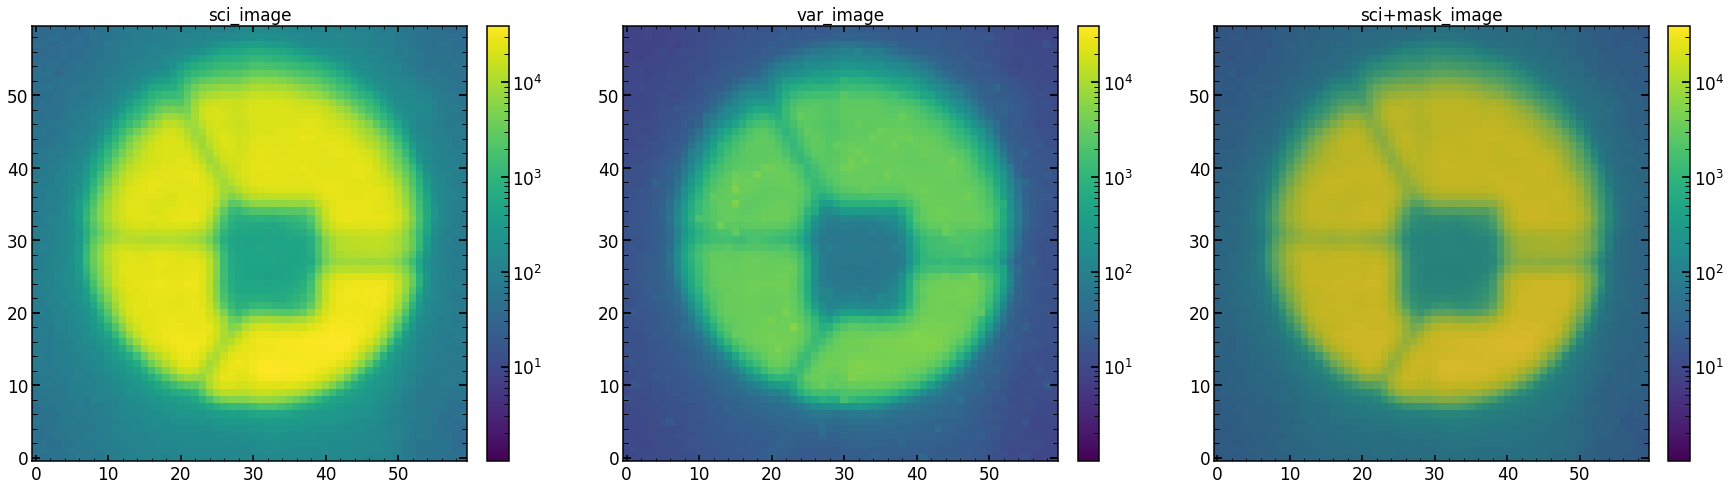

In [76]:
single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_long)
single_analysis.create_basic_data_image()

In [83]:
double_sources,double_sources_positions_ratios=single_analysis.return_double_sources()
list_of_sci_images,list_of_var_images,list_of_mask_images=single_analysis.return_lists_of_images()
index_of_single_image=single_analysis.return_index_of_single_image_in_list_of_images()
columns,columns22,columns22_analysis=single_analysis.return_columns()

chain0_swarm_1,likechain0_swarm_1=single_analysis.create_chains_swarm_1()
#chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain_parametrization,like_min=single_analysis.create_likelihood()

Swarm1 and likechainSwarm1 found
Path searched was: /Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Dec3020/chainDec3020_Single_P_34313566NeSwarm1.npy
Swarm1 and likechainSwarm1 found
Path searched was: /Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Dec3020/chainDec3020_Single_P_34313566NeSwarm1.npy
(61, 480, 129)
Swarm1 and likechainSwarm1 found
Path searched was: /Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Dec3020/chainDec3020_Single_P_34313566NeSwarm1.npy
(61, 480, 129)
minimal likelihood is: 4635.302356012223
average chi2 reduced is: 28.351149215024552


Text(0, 0.5, 'par_1')

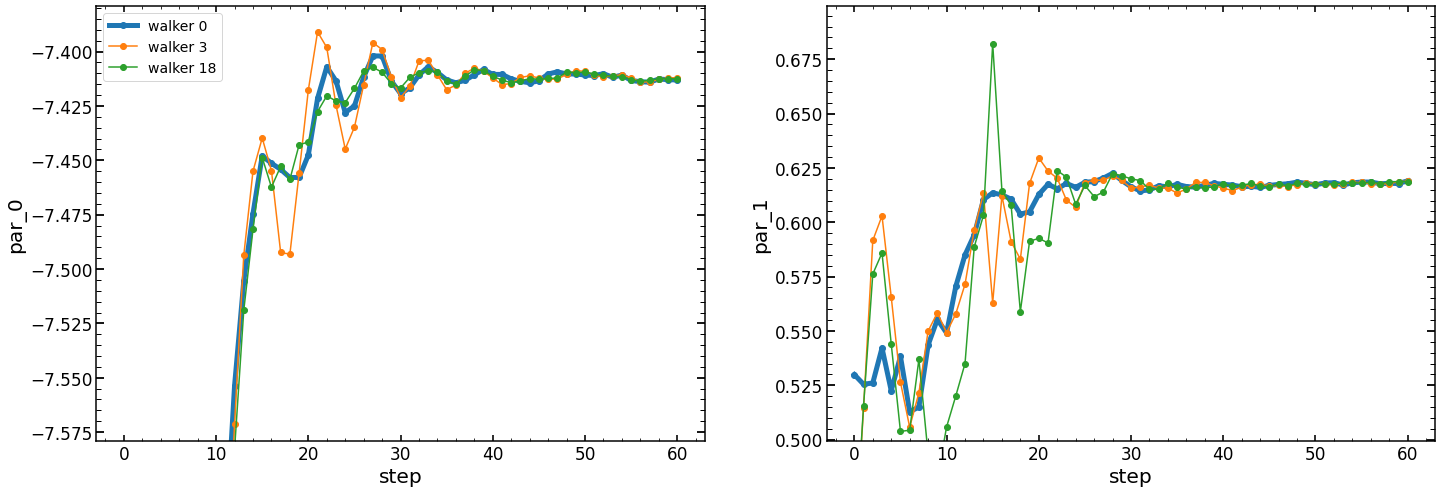

In [84]:
# wavefront paramter
plt.figure(figsize=(24,8))
i=0*2
plt.subplot(121)
# two different walkers, parameter 0
plt.plot(chain0_swarm_1[:,0][:,i],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i],label='walker 18',marker='o')
plt.xlabel('step')
plt.ylabel('par_'+str((i)))
mean_one_walker=np.mean(chain0_swarm_1[:,18][:,i])
plt.ylim(mean_one_walker-0.1,mean_one_walker+0.1)
plt.legend()

plt.subplot(122)
#  paramter 2 (z5)

mean_one_what=np.mean(chain0_swarm_1[:,:,i+1][:,2])
plt.plot(chain0_swarm_1[:,:,i+1][:,0],lw=5,marker='o')
plt.plot(chain0_swarm_1[:,:,i+1][:,3],marker='o')
plt.plot(chain0_swarm_1[:,:,i+1][:,18],marker='o')
plt.ylim(mean_one_what-0.1,mean_one_what+0.1)
plt.xlabel('step')
plt.ylabel('par_'+str((i+1)))

In [85]:
gbests_positions=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Dec3020/chainDec3020_Single_P_3443736Arres_gbests_position.npy')
gbests_positions.shape

(21, 129)

Text(0.5, 1.0, 'par_46 / wide_43')

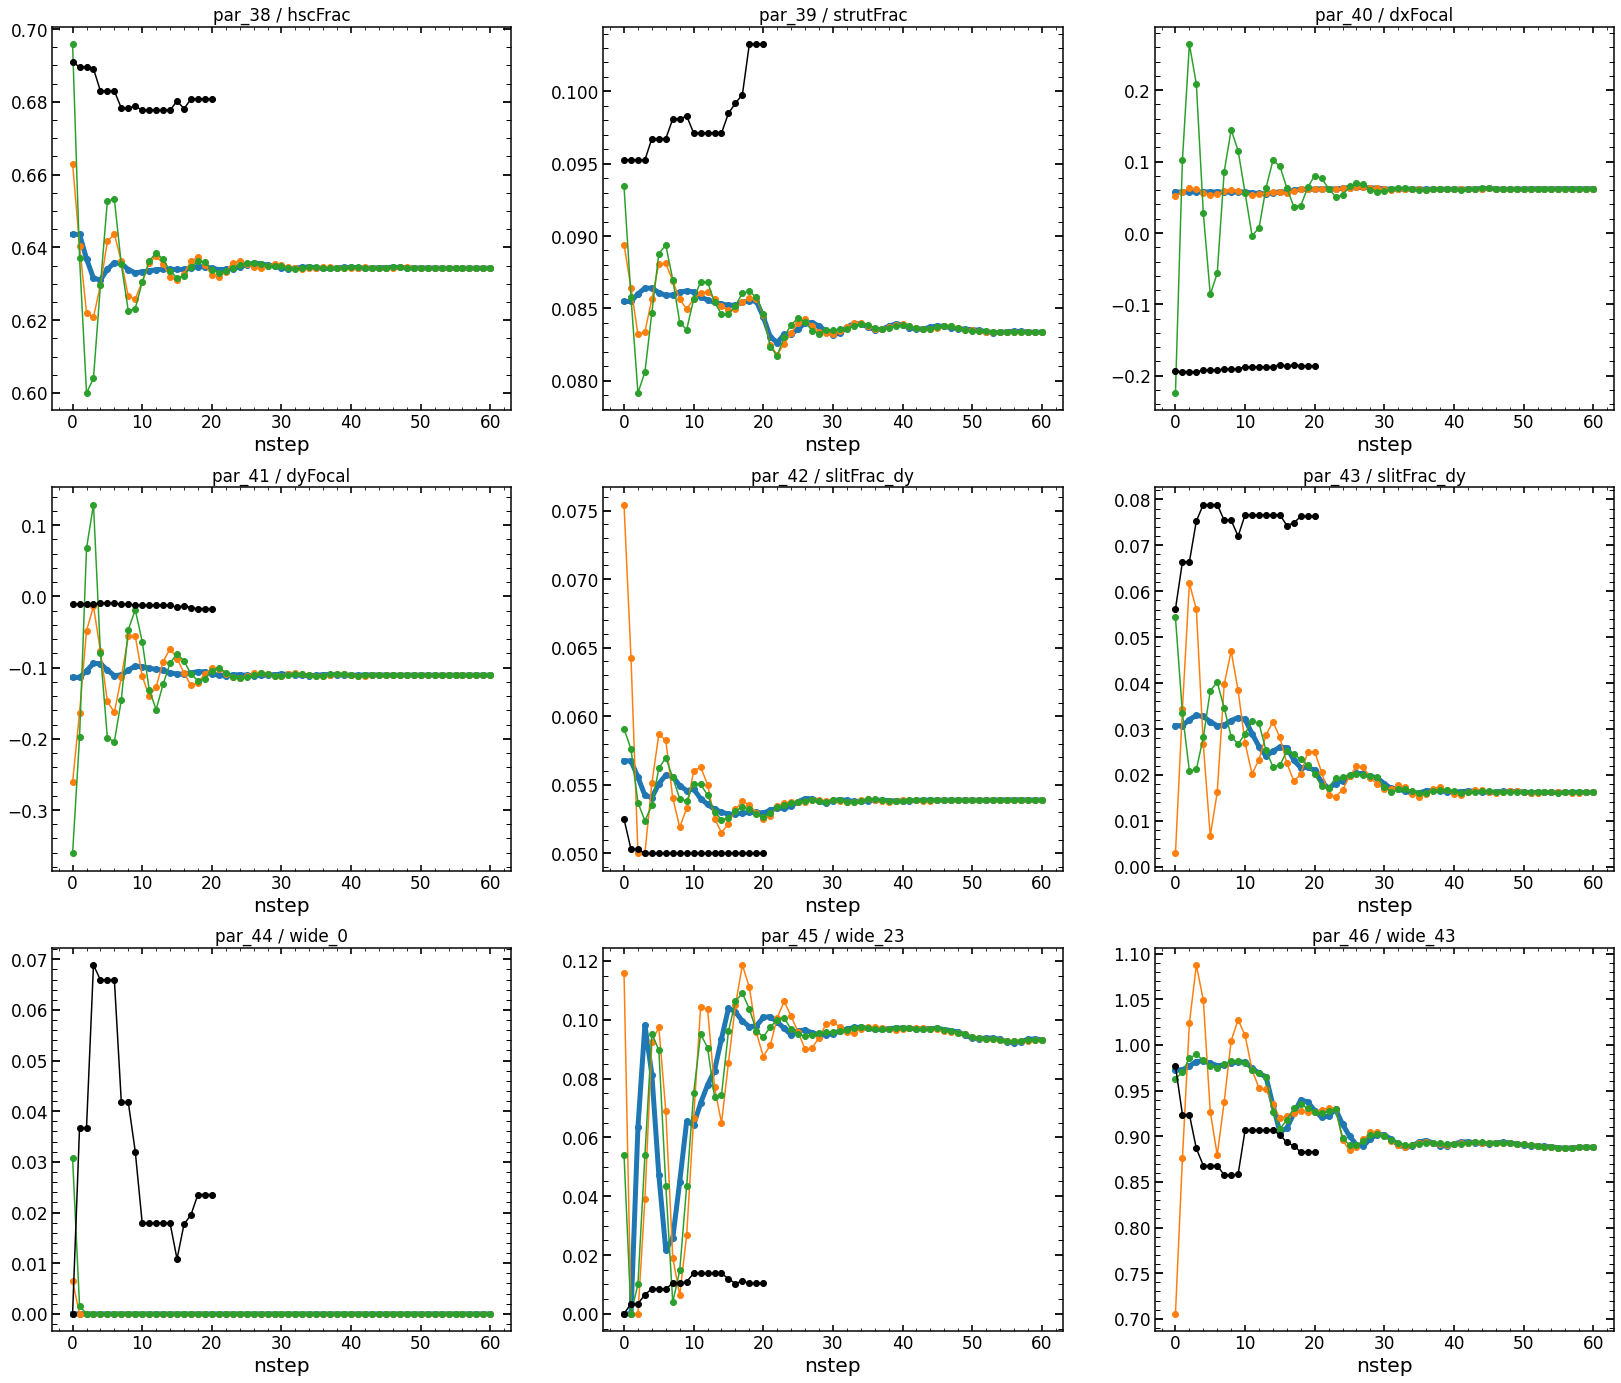

In [86]:
# pupil paramters
plt.figure(figsize=(28,24))
i=19*2
plt.subplot(331)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i))+' / '+columns22[19])

plt.subplot(332)
plt.plot(chain0_swarm_1[:,:,i+1][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+1][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+1][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+1],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+1))+' / '+columns22[20])

plt.subplot(333)
plt.plot(chain0_swarm_1[:,:,i+2][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+2][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+2][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+2],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+2))+' / '+columns22[21])



plt.subplot(334)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+3],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+3],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+3],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+3))+' / '+columns22[19+3])

plt.subplot(335)
plt.plot(chain0_swarm_1[:,:,i+4][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+4][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+4][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+4],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+4))+' / '+columns22[20+4])

plt.subplot(336)
plt.plot(chain0_swarm_1[:,:,i+5][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+5][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+5][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+5],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+5))+' / '+columns22[19+5])


plt.subplot(337)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+6],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+6],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+6],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+6],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+6))+' / '+columns22[19+6])

plt.subplot(338)
plt.plot(chain0_swarm_1[:,:,i+7][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+7][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+7][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+7],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+7))+' / '+columns22[19+7])

plt.subplot(339)
plt.plot(chain0_swarm_1[:,:,i+8][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+8][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+8][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+8],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+8))+' / '+columns22[19+8])


Text(0.5, 1.0, 'par_58 / pixel_effect')

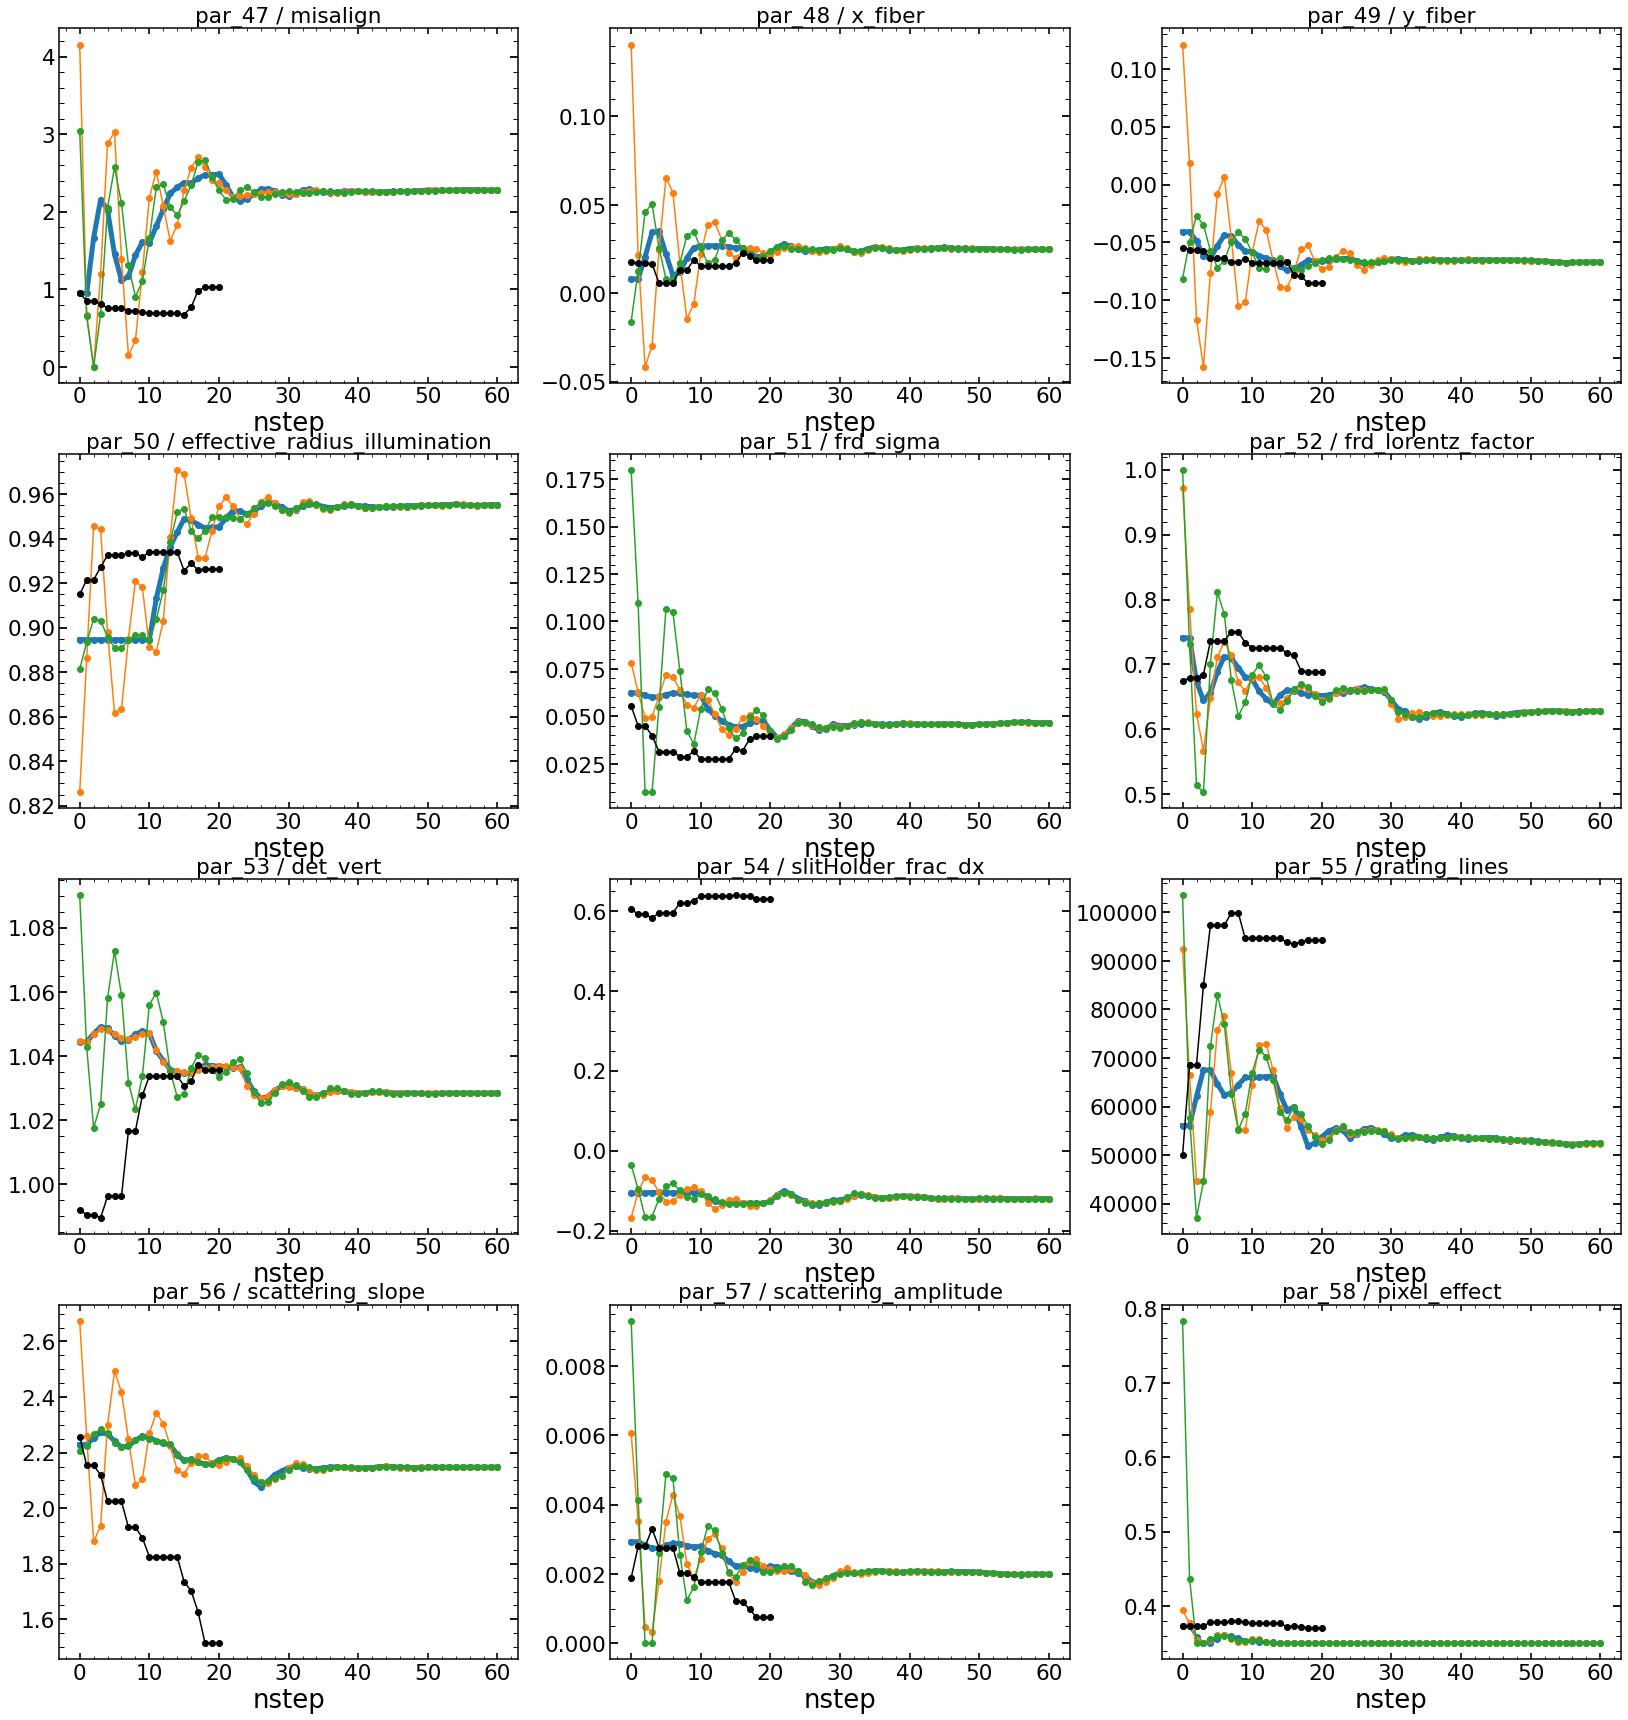

In [90]:
# pupil paramters
plt.figure(figsize=(28,30))
i=19*2
plt.subplot(431)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+9],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+9],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+9],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+9],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+9))+' / '+columns22[19+9])

plt.subplot(432)
plt.plot(chain0_swarm_1[:,:,i+10][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+10][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+10][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+10],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+10))+' / '+columns22[19+10])

plt.subplot(433)
plt.plot(chain0_swarm_1[:,:,i+11][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+11][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+11][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+11],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+11))+' / '+columns22[19+11])



plt.subplot(434)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+12],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+12],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+12],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+12],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+12))+' / '+columns22[19+12])

plt.subplot(435)
plt.plot(chain0_swarm_1[:,:,i+13][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+13][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+13][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+13],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+13))+' / '+columns22[19+13])

plt.subplot(436)
plt.plot(chain0_swarm_1[:,:,i+14][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+14][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+14][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+14],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+14))+' / '+columns22[19+14])


plt.subplot(437)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+15],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+15],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+15],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+15],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+15))+' / '+columns22[19+15])

plt.subplot(438)
plt.plot(chain0_swarm_1[:,:,i+16][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+16][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+16][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+16],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+16))+' / '+columns22[19+16])

plt.subplot(439)
plt.plot(chain0_swarm_1[:,:,i+17][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+17][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+17][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+17],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+17))+' / '+columns22[19+17])


plt.subplot(4,3,10)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+18],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+18],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+18],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+18))+' / '+columns22[19+18])

plt.subplot(4,3,11)
plt.plot(chain0_swarm_1[:,:,i+19][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+19][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+19][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+19],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+19))+' / '+columns22[19+19])

plt.subplot(4,3,12)
plt.plot(chain0_swarm_1[:,:,i+20][:,0],lw=3,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+20][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+20][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+20],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+20))+' / '+columns22[19+20])

Text(0, 0.5, 'std. devation of a single parameter 38')

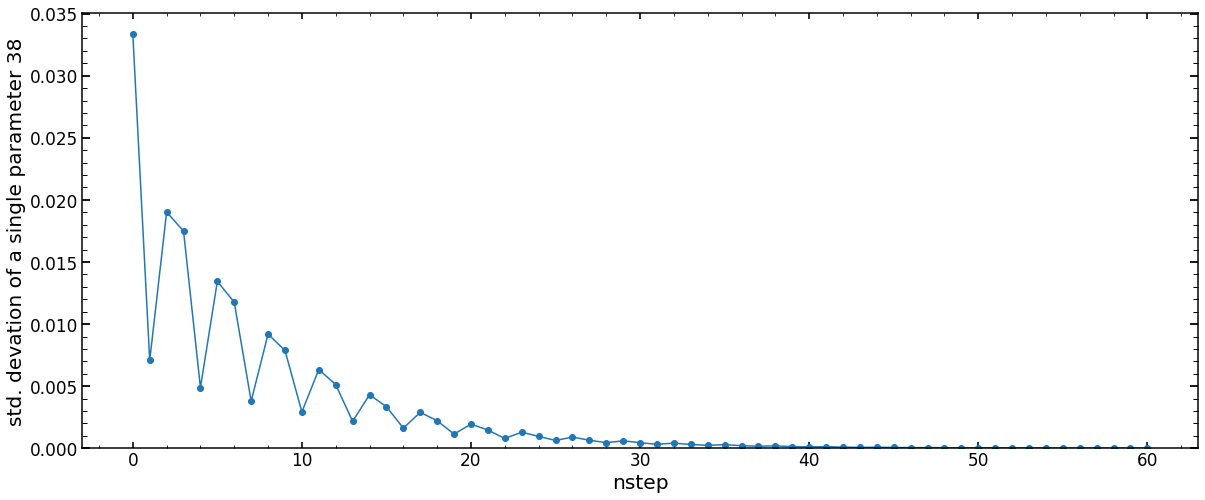

In [88]:
list_of_std=[]
i=19*2+0
for j in range(len(chain0_swarm_1)):
    list_of_std.append(np.std(chain0_swarm_1[:,:,i][j]))

plt.figure(figsize=(20,8))
plt.plot(list_of_std,marker='o')
plt.ylim(0)
plt.xlabel('nstep')
plt.ylabel('std. devation of a single parameter '+str(i))

Swarm1 and likechainSwarm1 found
Path searched was: /Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Dec3020/chainDec3020_Single_P_34313566NeSwarm1.npy
(61, 480, 129)
minimal likelihood is: 4635.302356012223
average chi2 reduced is: 28.351149215024552
Swarm1 and likechainSwarm1 found
Path searched was: /Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Dec3020/chainDec3020_Single_P_34313566NeSwarm1.npy
(61, 480, 129)


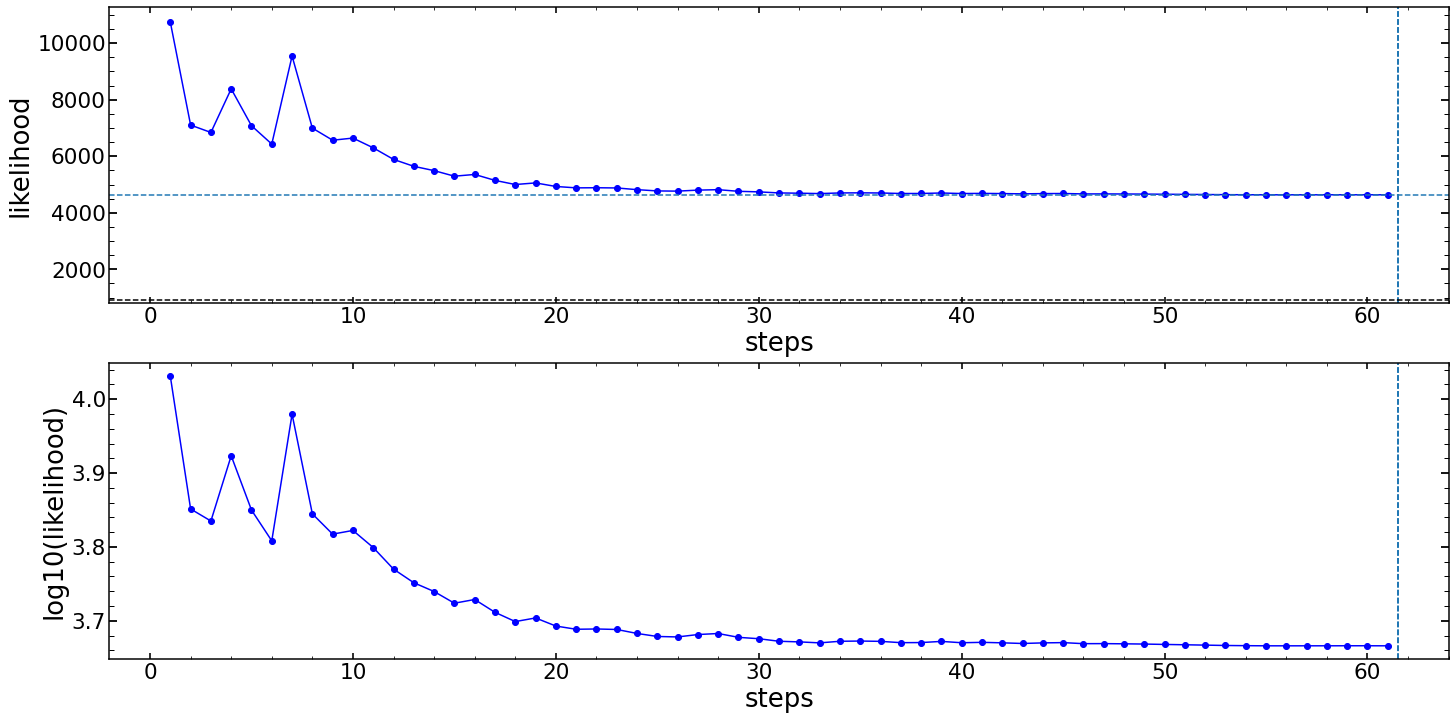

In [89]:
single_analysis.create_fitting_evolution_plot()

In [91]:
model_multi=LN_PFS_multi_same_spot(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=1,zmax=56,verbosity=1,\
                      double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=False)   

#list_of_minchain=model_multi.create_list_of_allparameters(t1,list_of_defocuses=list_of_defocuses_input_long,zmax=56)
list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=list_of_defocuses_input_long,zmax=22)
#list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=['m4','p4'],zmax=56)

res_multi=model_multi(list_of_minchain,return_Images=True)


mean_res_of_multi_same_spot,list_of_single_res,list_of_single_model_image,\
                list_of_single_allparameters,list_of_single_chi_results,array_of_psf_positions_output=res_multi

#model = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],dithering=1,save=1,zmax=22,verbosity=1,\
#                      double_sources=None,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)  

#res_with_Image=model(list_of_minchain[index_of_single_image],return_Image=True)

################################
analyzing image 1 out of 9
 
Science image shape is: (60, 60)
Top left pixel value of the science image is: 45.54016
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 9.426998
Mask image shape is: (60, 60)
Sum of mask image is: 0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.37
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56

Entering lnlike_Neven
allparameters [   30.27255866    -0.42046684    -0.91422445     0.43069779
    -0.15636367    -0.11679715    -0.2629492     -0.52893462
     0.04400507     0.04158884    -0.05620776     0.0300863
    -0.02651182     0.11915679     0.02114476    -0.00413499
    -0.03539087    -0.00413351     0.09447011     0.63429677
     0.08337452     0.06188617    -0.1104989      0.05390145
     0.0161324      0.    

chi2 within shgo optimization routine (chi_2_almost_multi_values): 316.62372
chi2 within shgo optimization routine (chi_2_almost_multi_values): 316.6238
chi2 within shgo optimization routine (chi_2_almost_multi_values): 316.62378
chi2 within shgo optimization routine (chi_2_almost_multi_values): 316.6238
chi2 within shgo optimization routine (chi_2_almost_multi_values): 316.6238
chi2 within shgo optimization routine (chi_2_almost_multi_values): 316.6237
chi2 within shgo optimization routine (chi_2_almost_multi_values): 316.62375
chi2 within shgo optimization routine (chi_2_almost_multi_values): 316.6238
chi2 within shgo optimization routine (chi_2_almost_multi_values): 316.62375
chi2 within shgo optimization routine (chi_2_almost_multi_values): 316.6238
chi2 within shgo optimization routine (chi_2_almost_multi_values): 316.6238
chi2 within shgo optimization routine (chi_2_almost_multi_values): 316.6238
chi2 within shgo optimization routine (chi_2_almost_multi_values): 316.6238
chi2 wit

chi2 within shgo optimization routine (chi_2_almost_multi_values): 2908.9763
chi2 within shgo optimization routine (chi_2_almost_multi_values): 786.886
chi2 within shgo optimization routine (chi_2_almost_multi_values): 391.63712
chi2 within shgo optimization routine (chi_2_almost_multi_values): 305.25116
chi2 within shgo optimization routine (chi_2_almost_multi_values): 285.27112
chi2 within shgo optimization routine (chi_2_almost_multi_values): 280.57538
chi2 within shgo optimization routine (chi_2_almost_multi_values): 279.52246
chi2 within shgo optimization routine (chi_2_almost_multi_values): 279.30936
chi2 within shgo optimization routine (chi_2_almost_multi_values): 279.2877
chi2 within shgo optimization routine (chi_2_almost_multi_values): 279.29776
chi2 within shgo optimization routine (chi_2_almost_multi_values): 279.2978
chi2 within shgo optimization routine (chi_2_almost_multi_values): 279.2978
chi2 within shgo optimization routine (chi_2_almost_multi_values): 25692.51
chi2 

We are fitting for only one source
One source fitting result is [-6.06714855  5.12949228]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 0.6933939456939697
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.995
Finished with lnlike_Neven
chi_2_almost/d.o.f is 277.84726; chi_2_almost_max_dof is 62549.863 log(improvment) is -2.3524203
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4373415360
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4373415360 is: 5.1564271450042725 seconds
 
###########################

chi2 within shgo optimization routine (chi_2_almost_multi_values): 253.07605
chi2 within shgo optimization routine (chi_2_almost_multi_values): 243.82306
chi2 within shgo optimization routine (chi_2_almost_multi_values): 242.74422
chi2 within shgo optimization routine (chi_2_almost_multi_values): 242.9996
chi2 within shgo optimization routine (chi_2_almost_multi_values): 243.32498
chi2 within shgo optimization routine (chi_2_almost_multi_values): 243.54074
chi2 within shgo optimization routine (chi_2_almost_multi_values): 243.66391
chi2 within shgo optimization routine (chi_2_almost_multi_values): 243.73038
chi2 within shgo optimization routine (chi_2_almost_multi_values): 243.73035
chi2 within shgo optimization routine (chi_2_almost_multi_values): 243.73035
chi2 within shgo optimization routine (chi_2_almost_multi_values): 243.78333
chi2 within shgo optimization routine (chi_2_almost_multi_values): 243.75635
chi2 within shgo optimization routine (chi_2_almost_multi_values): 243.74324


Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.99625
Finished with lnlike_Neven
chi_2_almost/d.o.f is 241.94855; chi_2_almost_max_dof is 72802.0 log(improvment) is -2.4784203
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4373415360
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4373415360 is: 5.685463190078735 seconds
 
################################
analyzing image 4 out of 9
 
Science image shape is: (20, 20)
Top left pixel value of the science image is: 7.3977766
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 3.6197407
Mask image shape is: (20, 20)
Sum of mask image is: 0
Dit

chi2 within shgo optimization routine (chi_2_almost_multi_values): 36.905792
chi2 within shgo optimization routine (chi_2_almost_multi_values): 36.848343
chi2 within shgo optimization routine (chi_2_almost_multi_values): 36.822376
chi2 within shgo optimization routine (chi_2_almost_multi_values): 36.82238
chi2 within shgo optimization routine (chi_2_almost_multi_values): 36.822384
chi2 within shgo optimization routine (chi_2_almost_multi_values): 58999.316
chi2 within shgo optimization routine (chi_2_almost_multi_values): 306.16193
chi2 within shgo optimization routine (chi_2_almost_multi_values): 82.38003
chi2 within shgo optimization routine (chi_2_almost_multi_values): 47.036007
chi2 within shgo optimization routine (chi_2_almost_multi_values): 39.470703
chi2 within shgo optimization routine (chi_2_almost_multi_values): 37.567024
chi2 within shgo optimization routine (chi_2_almost_multi_values): 37.05946
chi2 within shgo optimization routine (chi_2_almost_multi_values): 36.9083
chi2

Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.998004533647264
Finished with lnlike_Neven
chi_2_almost/d.o.f is 36.569305; chi_2_almost_max_dof is 16546.623 log(improvment) is -2.6555927
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4373415360
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4373415360 is: 4.445843935012817 seconds
 
################################
analyzing image 5 out of 9
 
Science image shape is: (20, 20)
Top left pixel value of the science image is: 2.2001657
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 2.9153485
Mask image shape is: (20, 20)
Sum of mask ima

chi2 within shgo optimization routine (chi_2_almost_multi_values): 176.17154
chi2 within shgo optimization routine (chi_2_almost_multi_values): 22.739117
chi2 within shgo optimization routine (chi_2_almost_multi_values): 10.090041
chi2 within shgo optimization routine (chi_2_almost_multi_values): 8.208081
chi2 within shgo optimization routine (chi_2_almost_multi_values): 7.9149766
chi2 within shgo optimization routine (chi_2_almost_multi_values): 7.901947
chi2 within shgo optimization routine (chi_2_almost_multi_values): 7.927915
chi2 within shgo optimization routine (chi_2_almost_multi_values): 7.949288
chi2 within shgo optimization routine (chi_2_almost_multi_values): 7.9622865
chi2 within shgo optimization routine (chi_2_almost_multi_values): 7.969495
chi2 within shgo optimization routine (chi_2_almost_multi_values): 7.9694977
chi2 within shgo optimization routine (chi_2_almost_multi_values): 7.969497
chi2 within shgo optimization routine (chi_2_almost_multi_values): 76.32953
chi2 w

Time to apodize the pupil: 0.13941192626953125
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.30393075942993164
Time for pupil and illumination calculation is 0.3116137981414795

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -3.08757623626557, -0.43754044000253767, -0.6738033046300053, 0.647306688986894, -0.36781680527415284, -0.10461713611638039, -0.16464933064587986, -0.2798766620515645, 0.06111817073694867, 0.04764193753807305, 0.021524799300064627, 0.03106071110104474, -0.0015698516021048717, 0.006224050998380038, 0.0009495746049176792, -0.007592898124258932, -0.02415193749990984, 0.0030693658225819246, -0.006762905077628859, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, -0.43754044000253767, -0.6738033046300053, 0.64

Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9986040461098673
Finished with lnlike_Neven
chi_2_almost/d.o.f is 14.881919; chi_2_almost_max_dof is 9631.509 log(improvment) is -2.8110354
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4373415360
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4373415360 is: 3.226135015487671 seconds
 
################################
analyzing image 7 out of 9
 
Science image shape is: (50, 50)
Top left pixel value of the science image is: 23.156742
Variance image shape is: (50, 50)
Top left pixel value of the variance image is: 6.0595503
Mask image shape is: (50, 50)
Sum of mask image is: 0
Dithering value is: 1

suppli

chi2 within shgo optimization routine (chi_2_almost_multi_values): 141.5025
chi2 within shgo optimization routine (chi_2_almost_multi_values): 143.63354
chi2 within shgo optimization routine (chi_2_almost_multi_values): 140.8833
chi2 within shgo optimization routine (chi_2_almost_multi_values): 141.6329
chi2 within shgo optimization routine (chi_2_almost_multi_values): 140.35165
chi2 within shgo optimization routine (chi_2_almost_multi_values): 141.37683
chi2 within shgo optimization routine (chi_2_almost_multi_values): 140.14189
chi2 within shgo optimization routine (chi_2_almost_multi_values): 143.11893
chi2 within shgo optimization routine (chi_2_almost_multi_values): 139.97855
chi2 within shgo optimization routine (chi_2_almost_multi_values): 140.13754
chi2 within shgo optimization routine (chi_2_almost_multi_values): 140.72192
chi2 within shgo optimization routine (chi_2_almost_multi_values): 139.9836
chi2 within shgo optimization routine (chi_2_almost_multi_values): 140.07005
chi

Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.99625
Finished with lnlike_Neven
chi_2_almost/d.o.f is 139.49443; chi_2_almost_max_dof is 41519.965 log(improvment) is -2.4737
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4373415360
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4373415360 is: 4.262760877609253 seconds
 
################################
analyzing image 8 out of 9
 
Science image shape is: (60, 60)
Top left pixel value of the science image is: 35.59974
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 7.855552
Mask image shape is: (60, 60)
Sum of mask image is: 0
Dither

chi2 within shgo optimization routine (chi_2_almost_multi_values): 179.44272
chi2 within shgo optimization routine (chi_2_almost_multi_values): 179.47433
chi2 within shgo optimization routine (chi_2_almost_multi_values): 179.49055
chi2 within shgo optimization routine (chi_2_almost_multi_values): 179.49889
chi2 within shgo optimization routine (chi_2_almost_multi_values): 179.50311
chi2 within shgo optimization routine (chi_2_almost_multi_values): 179.50528
chi2 within shgo optimization routine (chi_2_almost_multi_values): 179.50642
chi2 within shgo optimization routine (chi_2_almost_multi_values): 179.50696
chi2 within shgo optimization routine (chi_2_almost_multi_values): 179.50726
chi2 within shgo optimization routine (chi_2_almost_multi_values): 179.50743
chi2 within shgo optimization routine (chi_2_almost_multi_values): 179.5075
chi2 within shgo optimization routine (chi_2_almost_multi_values): 179.5075
chi2 within shgo optimization routine (chi_2_almost_multi_values): 173.80467
c

Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.99625
Finished with lnlike_Neven
chi_2_almost/d.o.f is 168.97836; chi_2_almost_max_dof is 39869.09 log(improvment) is -2.372805
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4373415360
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4373415360 is: 5.112897157669067 seconds
 
################################
analyzing image 9 out of 9
 
Science image shape is: (60, 60)
Top left pixel value of the science image is: 41.682804
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 8.828835
Mask image shape is: (60, 60)
Sum of mask image is: 0
Dith

chi2 within shgo optimization routine (chi_2_almost_multi_values): 273.60312
chi2 within shgo optimization routine (chi_2_almost_multi_values): 273.60165
chi2 within shgo optimization routine (chi_2_almost_multi_values): 273.6018
chi2 within shgo optimization routine (chi_2_almost_multi_values): 273.60117
chi2 within shgo optimization routine (chi_2_almost_multi_values): 273.60355
chi2 within shgo optimization routine (chi_2_almost_multi_values): 273.60083
chi2 within shgo optimization routine (chi_2_almost_multi_values): 273.6018
chi2 within shgo optimization routine (chi_2_almost_multi_values): 273.60104
chi2 within shgo optimization routine (chi_2_almost_multi_values): 273.60083
chi2 within shgo optimization routine (chi_2_almost_multi_values): 273.6013
chi2 within shgo optimization routine (chi_2_almost_multi_values): 273.6009
chi2 within shgo optimization routine (chi_2_almost_multi_values): 273.601
chi2 within shgo optimization routine (chi_2_almost_multi_values): 273.6008
chi2 w

-5637.279855371603


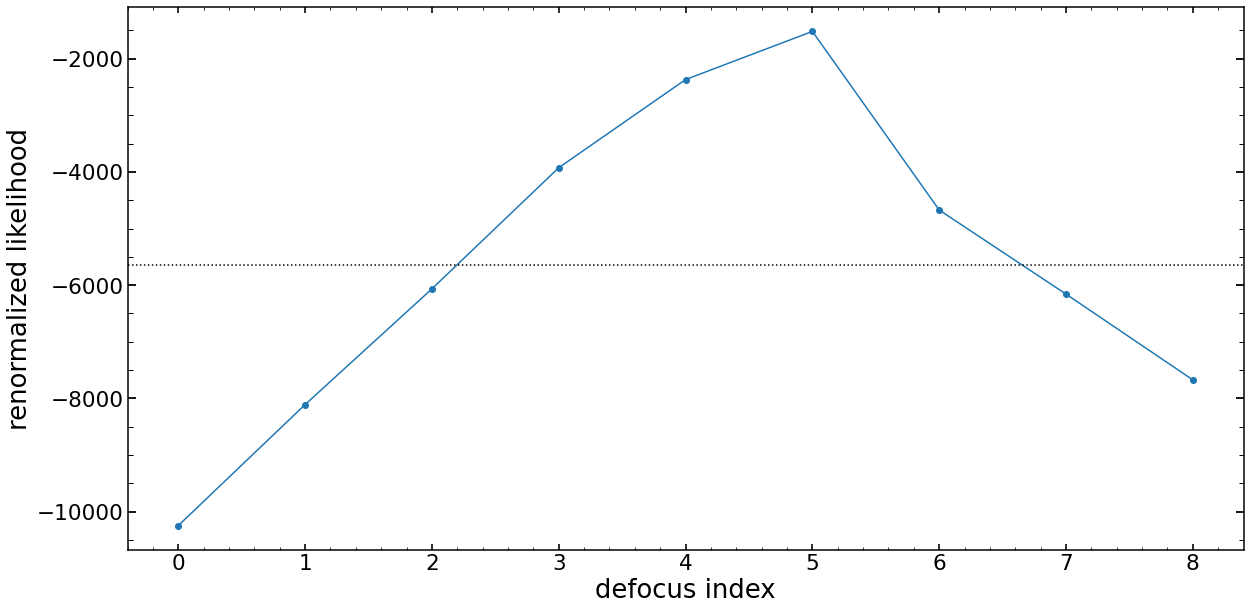

In [92]:
plt.figure(figsize=(20,10))
array_of_single_res=np.array(list_of_single_res)
renormalization_of_var_sum=np.array([56.53430254, 43.94541495, 32.92444707,  2.11628879,  1.,          2.56388188,
 39.0422126 , 51.24227782, 65.48594963])
mean_res_of_multi_same_spot=np.mean(array_of_single_res/renormalization_of_var_sum)
print(mean_res_of_multi_same_spot)
plt.plot(array_of_single_res/renormalization_of_var_sum,marker='o')
plt.xlabel('defocus index')
plt.ylabel('renormalized likelihood')
plt.axhline(mean_res_of_multi_same_spot,color='black',ls=":")

In [93]:
minchain=list_of_minchain[0]

print('minchain.shape '+str(minchain.shape))

    
dfz11 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns22[0:8])
print(dfz11)
print('##############################################')
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][8:19]]),columns=columns22[8:19])
print(dfz22)

print('')
#dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][19:len(columns)]]),columns=columns[19:])
print('##############################################')
dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][19:19+6]]),columns=columns22[19:19+6])
print(dfglobal1)
print('##############################################')
dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][25:25+4]]),columns=columns22[25:25+4])
print(dfglobal2)
print('##############################################')
dfglobal3 = pd.DataFrame(np.array([np.array([minchain])[0][29:29+5]]),columns=columns22[29:29+5])
print(dfglobal3)
print('##############################################')
dfglobal4 = pd.DataFrame(np.array([np.array([minchain])[0][34:41]]),columns=columns22[34:41])
print(dfglobal4)

minchain.shape (42,)
          z4        z5        z6        z7        z8        z9       z10  \
0  30.272559 -0.420467 -0.914224  0.430698 -0.156364 -0.116797 -0.262949   

        z11  
0 -0.528935  
##############################################
        z12       z13       z14       z15       z16       z17       z18  \
0  0.044005  0.041589 -0.056208  0.030086 -0.026512  0.119157  0.021145   

        z19       z20       z21      z22  
0 -0.004135 -0.035391 -0.004134  0.09447  

##############################################
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy
0  0.634297   0.083375  0.061886 -0.110499  0.053901     0.016132
##############################################
   wide_0   wide_23   wide_43  misalign
0     0.0  0.092634  0.888013  2.282432
##############################################
    x_fiber   y_fiber  effective_radius_illumination  frd_sigma  \
0  0.024738 -0.067544                       0.955213   0.047118   

   frd_lorentz_factor  
0

(-2.8, -1.5)

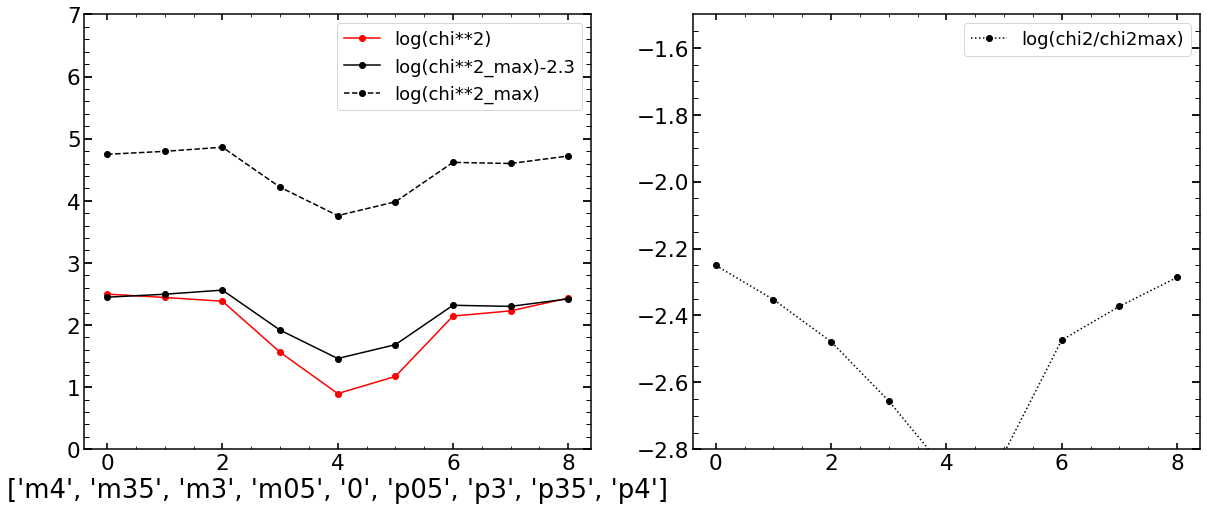

In [94]:
chi_results_array=np.array(res_multi[4])

plt.figure(figsize=(20,8))

plt.subplot(121)

plt.plot(np.log10(chi_results_array[:,2]),color='red',label='log(chi**2)',marker='o')
plt.plot(np.log10(chi_results_array[:,3])-2.3,color='black',label='log(chi**2_max)-2.3',marker='o')
plt.plot(np.log10(chi_results_array[:,3]),color='black',label='log(chi**2_max)',marker='o',ls='--')
plt.ylim(0,7)
plt.xlabel(list_of_defocuses_input_long)
plt.legend()
plt.subplot(122)

plt.plot(np.log10(chi_results_array[:,2]/chi_results_array[:,3]),color='black',label='log(chi2/chi2max)',marker='o',ls=':')
plt.legend()
plt.ylim(-2.8,-1.5)

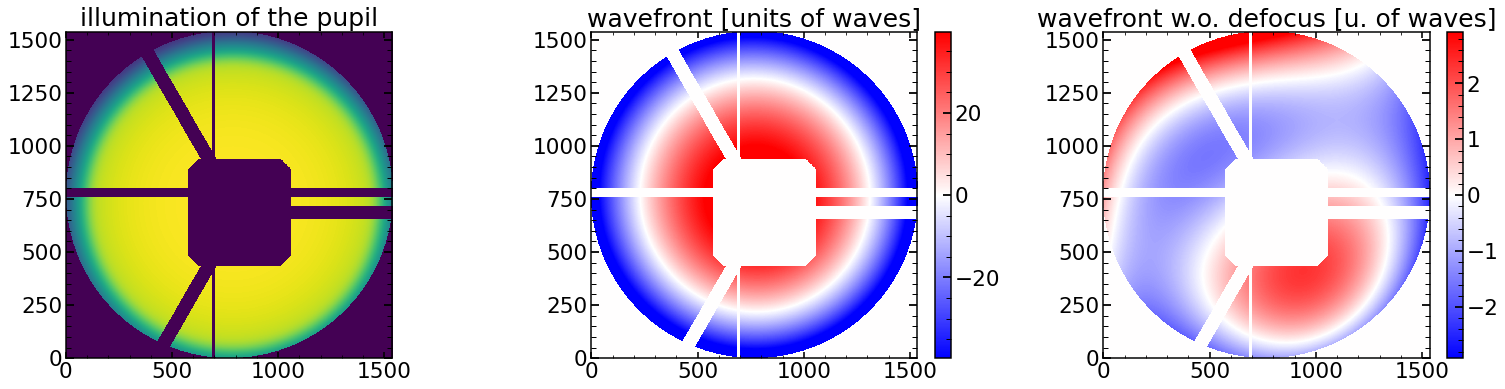

In [95]:
single_analysis.illumination_wavefront_plot()

chi**2 reduced is: 7.8890524
chi**2 reduced within mask area is: 4.784012
Abs of residual divided by total flux is: 0.023256317
Abs of residual divided by largest value of a flux in the image is: 0.025308771


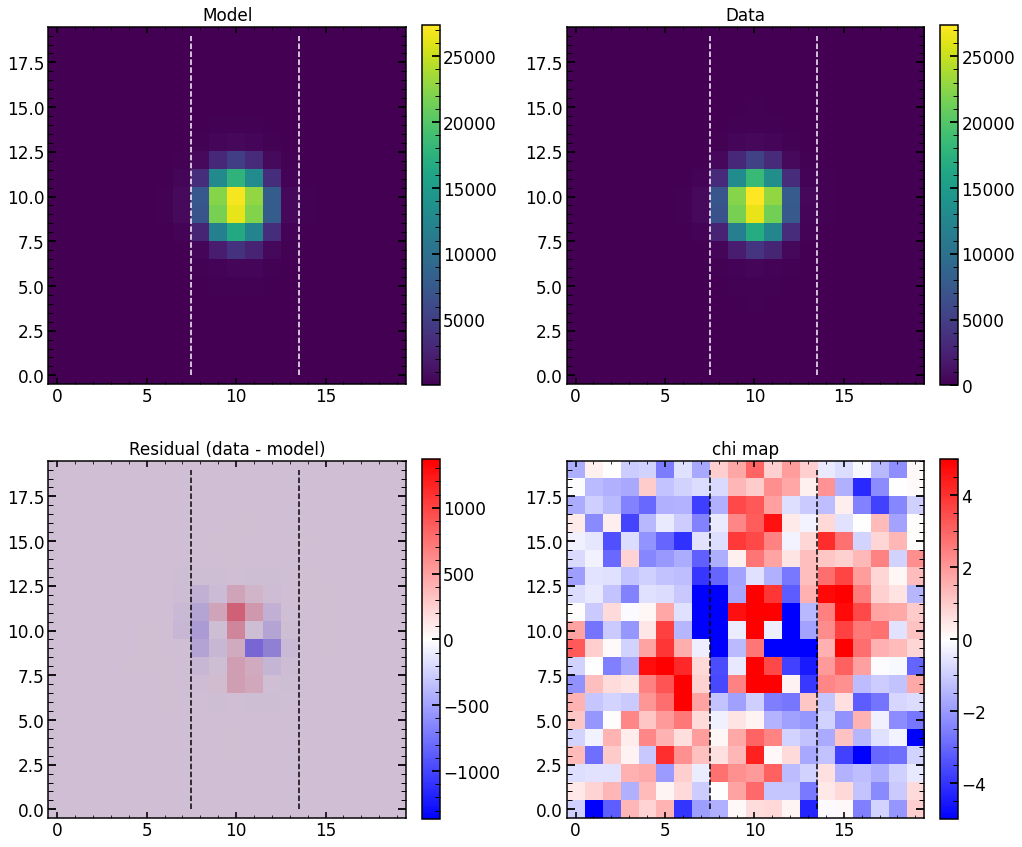

In [96]:
index_of_single_image=4

matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],custom_mask=list_of_mask_images[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image],\
                                             show_flux_mask=False)

chi**2 max reduced is: 5766.375
chi**2 reduced is: 7.8890524
Abs of residual divided by total flux is: 0.023256317
Abs of residual divided by largest value of a flux in the image is: 0.025308771


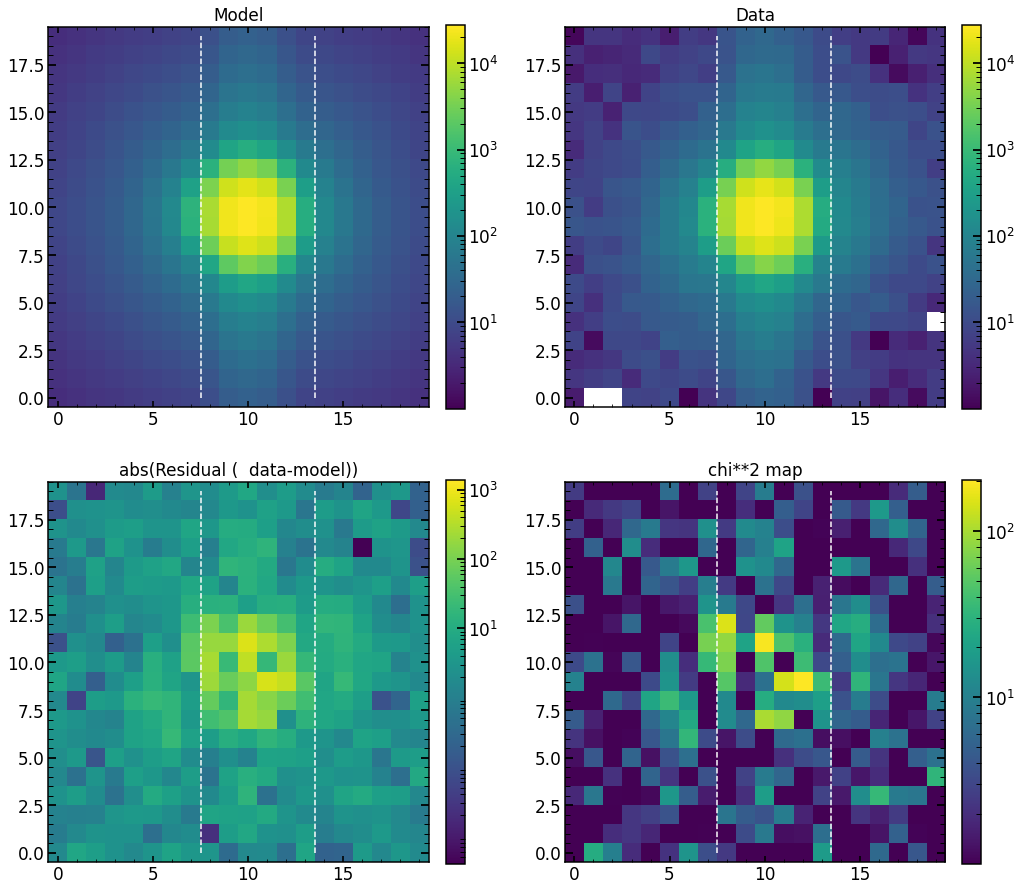

In [97]:
single_analysis.create_basic_comparison_plot_log(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image],\
                                                show_flux_mask=False)

7.8890524
chi**2 reduced is: 7.8890524
Abs of residual divided by total flux is: 0.023256317
Abs of residual divided by largest value of a flux in the image is: 0.025308771


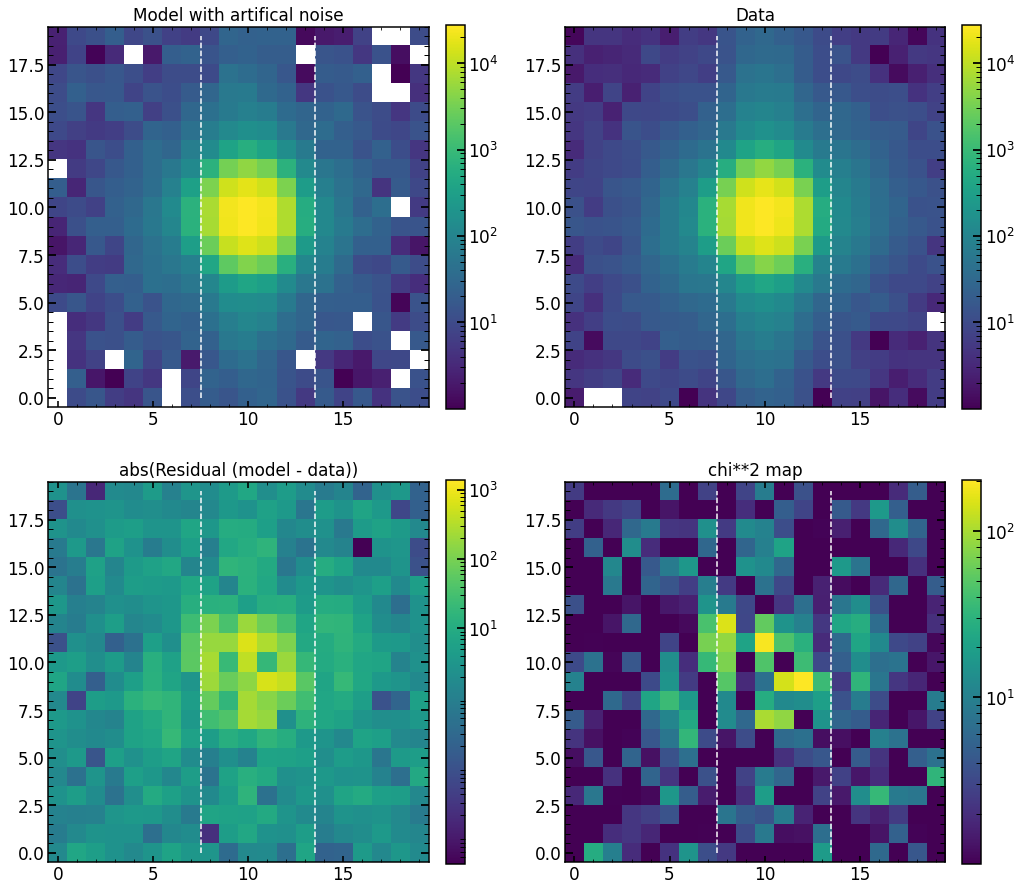

In [98]:
single_analysis.create_basic_comparison_plot_log_artifical(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image])

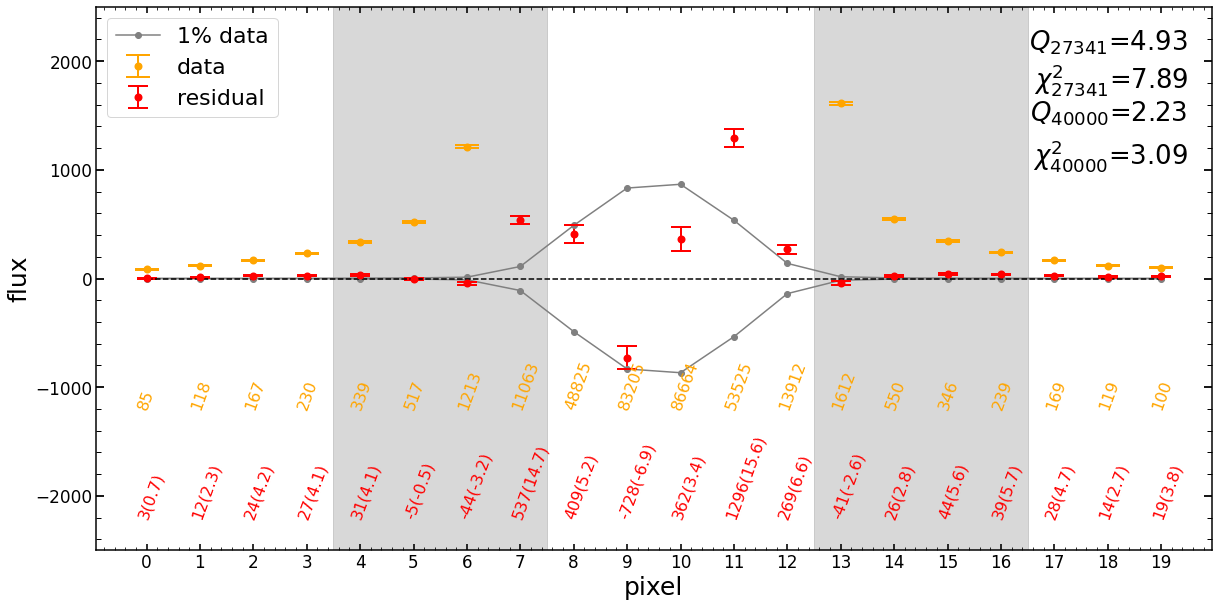

In [99]:
index_of_single_image=4
plot_1D_residual(sci_image=list_of_sci_images[index_of_single_image],var_image=list_of_var_images[index_of_single_image],model_image=list_of_single_model_image[index_of_single_image])

# Pipe2D-645

In [355]:
STAMPS_FOLDER='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/'
arc='Ne'
obs_v=34217+48
single_number=0
sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs_v)+str(single_number)+str(arc)+'_Stacked.npy')
print(obs_v)

34265


In [356]:
find_centroid_of_flux(sci_image)

(9.672992642697613, 10.3824115347422)

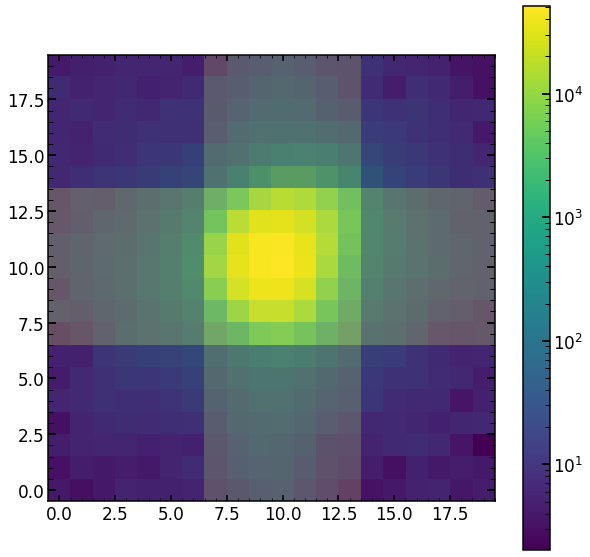

In [357]:
plt.figure(figsize=(10,10))
plt.imshow(sci_image,norm=LogNorm())

plt.colorbar()
cut_mask=np.zeros(sci_image.shape)
cut_mask[:,7:14]=1

cut_mask2=np.zeros(sci_image.shape)
cut_mask2[7:14]=1


plt.imshow(cut_mask,alpha=0.2)
plt.imshow(cut_mask2,alpha=0.2)


In [358]:
np.max(sci_image)

50864.69

3.3099999999999987


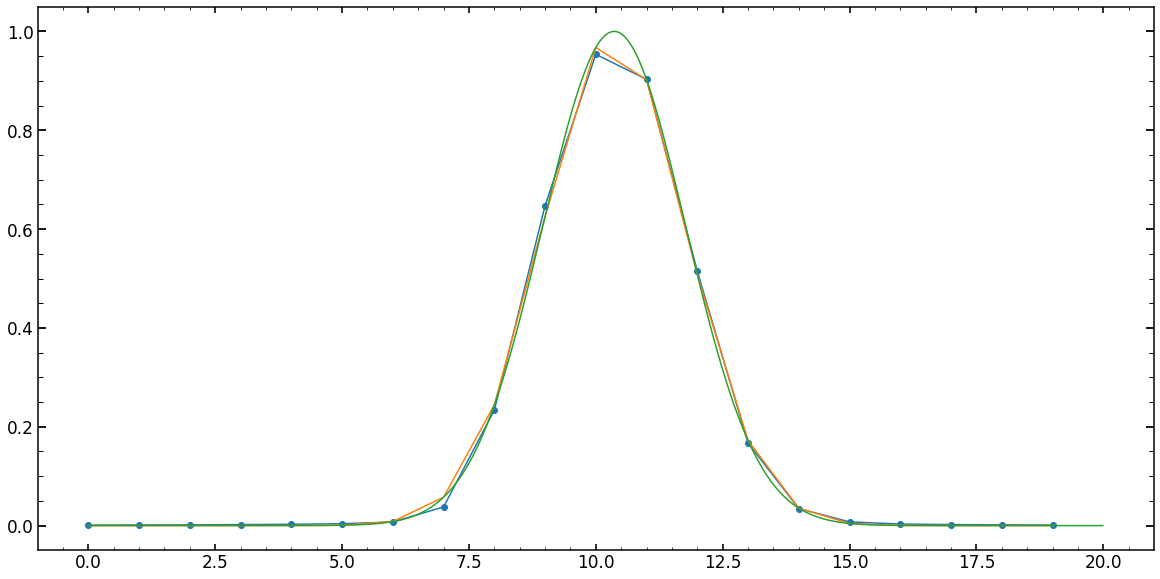

In [359]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 10., 2.8]

data=np.sum(sci_image[:,7:13],axis=1)
data=data/np.max(data)


bin_centres=np.arange(0,20)
bin_centres_fine=np.arange(0,20,0.01)
coeff, var_matrix = curve_fit(gauss, np.arange(0,20,1), data, p0=p0)

hist_fit_fine = gauss(bin_centres_fine, *coeff)

hist_fit_fine_max=np.max(hist_fit_fine)
hist_fit_fine=hist_fit_fine/hist_fit_fine_max

data=data/hist_fit_fine_max

hist_fit = gauss(bin_centres, *coeff)
hist_fit=hist_fit/hist_fit_fine_max

plt.figure(figsize=(20,10))
plt.plot(data, label='raw data',marker='o')
plt.plot(bin_centres, hist_fit, label='Fitted data')
plt.plot(bin_centres_fine, hist_fit_fine, label='Fitted data')

bins_above_05=bin_centres_fine[hist_fit_fine>0.499]

FWHM=bins_above_05[-1]-bins_above_05[0]

print(FWHM)

In [340]:
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalAr_Feb2020.pkl', 'rb') as f:
    finalAr_Feb2020_dataset=pickle.load(f) 
    
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalNe_Feb2020', 'rb') as f:
    finalNe_Feb2020_dataset=pickle.load(f) 
    
with open('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalKr_Feb2020', 'rb') as f:
    finalKr_Feb2020_dataset=pickle.load(f) 

In [341]:
len(finalNe_Feb2020_dataset)

90

In [398]:
# Argon 
arc='Ar'
obs_v=34341+48
FWHM_per_spot=[]
for single_number in range(0,120):
    try:
        sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs_v)+str(single_number)+str(arc)+'_Stacked.npy')
        data=np.sum(sci_image[:,7:13],axis=1)
        data=data/np.max(data)
        coeff, var_matrix = curve_fit(gauss, np.arange(0,20,1), data, p0=p0)

        hist_fit_fine = gauss(bin_centres_fine, *coeff)
        hist_fit_fine_max=np.max(hist_fit_fine)
        
        hist_fit_fine=hist_fit_fine/hist_fit_fine_max
        
        bins_above_05=bin_centres_fine[hist_fit_fine>0.499]

        FWHM=bins_above_05[-1]-bins_above_05[0]
        if FWHM>3.2:
            print([arc,single_number])

        FWHM_per_spot.append([single_number,FWHM])
    except:
        pass
    
FWHM_per_spot_Ar=np.array(FWHM_per_spot)


# Neon 
arc='Ne'
obs_v=34217+48
FWHM_per_spot=[]
for single_number in range(0,len(finalNe_Feb2020_dataset)):
    try:
        sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs_v)+str(single_number)+str(arc)+'_Stacked.npy')
        data=np.sum(sci_image[:,7:13],axis=1)

        coeff, var_matrix = curve_fit(gauss, np.arange(0,20,1), data, p0=p0)

        hist_fit_fine = gauss(bin_centres_fine, *coeff)
        hist_fit_fine_max=np.max(hist_fit_fine)
        
        hist_fit_fine=hist_fit_fine/hist_fit_fine_max
        
        bins_above_05=bin_centres_fine[hist_fit_fine>0.499]

        FWHM=bins_above_05[-1]-bins_above_05[0]
        if FWHM>3.2:
            print([arc,single_number])

        FWHM_per_spot.append([single_number,FWHM])
    except:
        pass
    
FWHM_per_spot_Ne=np.array(FWHM_per_spot)

# Krypon 
arc='Kr'
obs_v=34561+48
FWHM_per_spot=[]
for single_number in range(0,len(finalKr_Feb2020_dataset)):
    try:
        sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs_v)+str(single_number)+str(arc)+'_Stacked.npy')
        data=np.sum(sci_image[:,7:13],axis=1)

        coeff, var_matrix = curve_fit(gauss, np.arange(0,20,1), data, p0=p0)

        hist_fit_fine = gauss(bin_centres_fine, *coeff)
        hist_fit_fine_max=np.max(hist_fit_fine)
        
        hist_fit_fine=hist_fit_fine/hist_fit_fine_max
        
        bins_above_05=bin_centres_fine[hist_fit_fine>0.499]

        FWHM=bins_above_05[-1]-bins_above_05[0]
        if FWHM>3.2:
            print([arc,single_number])

        FWHM_per_spot.append([single_number,FWHM])
    except:
        pass
    
FWHM_per_spot_Kr=np.array(FWHM_per_spot)



['Ar', 11]
['Ar', 23]
['Ar', 107]
['Ar', 119]
['Ne', 0]
['Ne', 1]
['Ne', 2]
['Ne', 3]
['Ne', 7]
['Ne', 16]
['Ne', 34]
['Ne', 43]
['Ne', 79]


In [399]:
STAMPS_FOLDER+'sci'+str(obs_v)+str(single_number)+str(arc)+'_Stacked.npy'

'/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/sci3460939Kr_Stacked.npy'

In [400]:
wv_Ar=(finalAr_Feb2020_dataset.loc[FWHM_per_spot_Ar[:,0]]['wavelength']).values.astype(float)
wv_Ne=(finalNe_Feb2020_dataset.loc[FWHM_per_spot_Ne[:,0]]['wavelength']).values.astype(float)
wv_Kr=(finalKr_Feb2020_dataset.loc[FWHM_per_spot_Kr[:,0]]['wavelength']).values.astype(float)

In [401]:
x_Ar=finalAr_Feb2020_dataset.loc[FWHM_per_spot_Ar[:,0].astype(int).ravel()]['xc_effective'].values
y_Ar=finalAr_Feb2020_dataset.loc[FWHM_per_spot_Ar[:,0].astype(int).ravel()]['yc'].values
values_Ar_vw=FWHM_per_spot_Ar[:,1]


x_Ne=finalNe_Feb2020_dataset.loc[FWHM_per_spot_Ne[:,0].astype(int).ravel()]['xc_effective'].values
y_Ne=finalNe_Feb2020_dataset.loc[FWHM_per_spot_Ne[:,0].astype(int).ravel()]['yc'].values
values_Ne_vw=FWHM_per_spot_Ne[:,1]

x_Kr=finalKr_Feb2020_dataset.loc[FWHM_per_spot_Kr[:,0].astype(int).ravel()]['xc_effective'].values
y_Kr=finalKr_Feb2020_dataset.loc[FWHM_per_spot_Kr[:,0].astype(int).ravel()]['yc'].values
values_Kr_vw=FWHM_per_spot_Kr[:,1]


Text(0.5, 0, 'FWHM lsf')

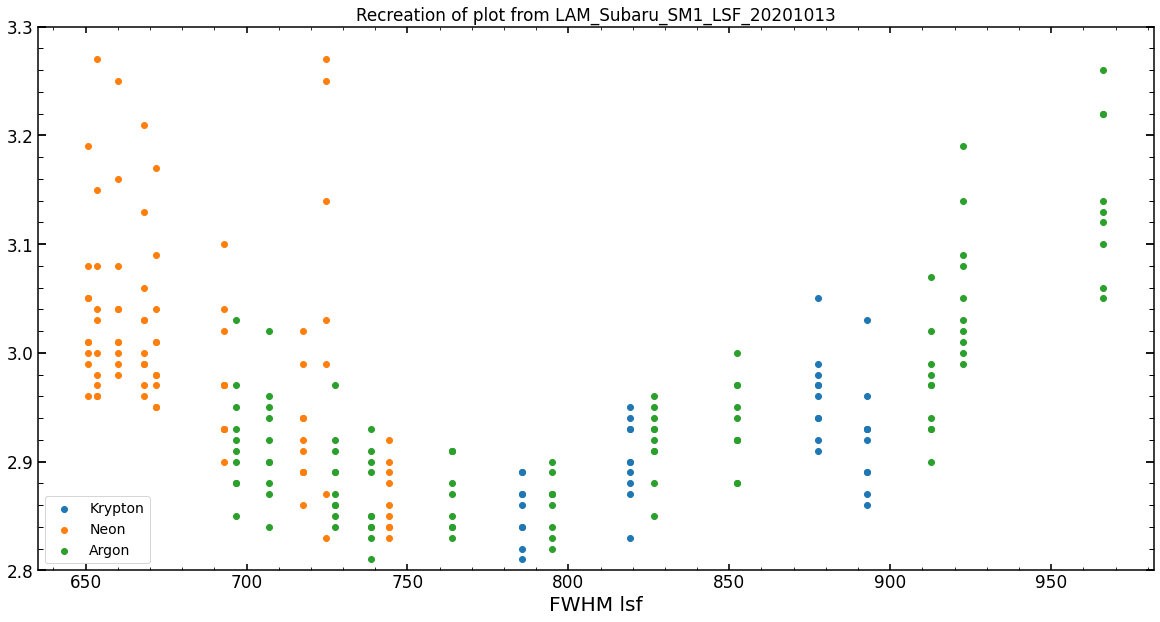

In [407]:
plt.figure(figsize=(20,10))
plt.scatter(wv_Kr,FWHM_per_spot_Kr[:,1],label='Krypton')
plt.scatter(wv_Ne,FWHM_per_spot_Ne[:,1],label='Neon')
plt.scatter(wv_Ar,FWHM_per_spot_Ar[:,1],label='Argon')

plt.ylim(2.8,3.3)
plt.legend()
plt.title('Recreation of plot from LAM_Subaru_SM1_LSF_20201013')
plt.xlabel('wavelength')
plt.xlabel('FWHM lsf')

In [394]:
# Argon 
arc='Ar'
obs_v=34341+48
FWHM_per_spot=[]
for single_number in range(0,120):
    try:
        sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs_v)+str(single_number)+str(arc)+'_Stacked.npy')
        data=np.sum(sci_image[7:13],axis=0)

        coeff, var_matrix = curve_fit(gauss, np.arange(0,20,1), data, p0=p0)

        hist_fit_fine = gauss(bin_centres_fine, *coeff)
        hist_fit_fine_max=np.max(hist_fit_fine)
        
        hist_fit_fine=hist_fit_fine/hist_fit_fine_max
        
        bins_above_05=bin_centres_fine[hist_fit_fine>0.499]

        FWHM=bins_above_05[-1]-bins_above_05[0]
        if FWHM>3.2:
            print([arc,single_number])
            
        FWHM_per_spot.append([single_number,FWHM])
    except:
        pass
    
FWHM_per_spot_Ar=np.array(FWHM_per_spot)


# Neon 
arc='Ne'
obs_v=34217+48
FWHM_per_spot=[]
for single_number in range(0,len(finalNe_Feb2020_dataset)):
    try:
        sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs_v)+str(single_number)+str(arc)+'_Stacked.npy')
        data=np.sum(sci_image[7:13],axis=0)

        coeff, var_matrix = curve_fit(gauss, np.arange(0,20,1), data, p0=p0)

        hist_fit_fine = gauss(bin_centres_fine, *coeff)
        hist_fit_fine_max=np.max(hist_fit_fine)
        
        hist_fit_fine=hist_fit_fine/hist_fit_fine_max
        
        bins_above_05=bin_centres_fine[hist_fit_fine>0.499]

        FWHM=bins_above_05[-1]-bins_above_05[0]
        if FWHM>3.2:
            print([arc,single_number])
        FWHM_per_spot.append([single_number,FWHM])
    except:
        pass
    
FWHM_per_spot_Ne=np.array(FWHM_per_spot)

# Krypon 
arc='Kr'
obs_v=34561+48
FWHM_per_spot=[]
for single_number in range(0,len(finalKr_Feb2020_dataset)):
    try:
        sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs_v)+str(single_number)+str(arc)+'_Stacked.npy')
        data=np.sum(sci_image[7:13],axis=0)

        coeff, var_matrix = curve_fit(gauss, np.arange(0,20,1), data, p0=p0)

        hist_fit_fine = gauss(bin_centres_fine, *coeff)
        hist_fit_fine_max=np.max(hist_fit_fine)
        
        hist_fit_fine=hist_fit_fine/hist_fit_fine_max
        
        bins_above_05=bin_centres_fine[hist_fit_fine>0.499]

        FWHM=bins_above_05[-1]-bins_above_05[0]
        if FWHM>3.2:
            print([arc,single_number])

        FWHM_per_spot.append([single_number,FWHM])
    except:
        pass
    
FWHM_per_spot_Kr=np.array(FWHM_per_spot)

['Ar', 119]
['Ne', 7]
['Ne', 16]
['Ne', 43]
['Ne', 52]
['Ne', 61]
['Ne', 79]
['Ne', 88]


In [379]:
wv_Ar_per_x=(finalAr_Feb2020_dataset.loc[FWHM_per_spot_Ar[:,0]]['wavelength']).values.astype(float)
wv_Ne_per_x=(finalNe_Feb2020_dataset.loc[FWHM_per_spot_Ne[:,0]]['wavelength']).values.astype(float)
wv_Kr_per_x=(finalKr_Feb2020_dataset.loc[FWHM_per_spot_Kr[:,0]]['wavelength']).values.astype(float)

(2.6, 3.2)

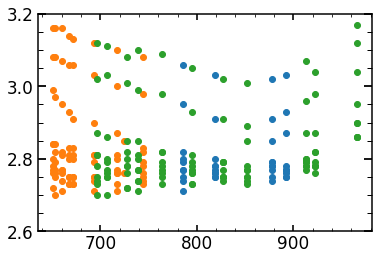

In [380]:
plt.scatter(wv_Kr_per_x,FWHM_per_spot_Kr[:,1])
plt.scatter(wv_Ne_per_x,FWHM_per_spot_Ne[:,1])
plt.scatter(wv_Ar_per_x,FWHM_per_spot_Ar[:,1])

plt.ylim(2.6,3.2)

In [381]:
x_Ar_per_x=finalAr_Feb2020_dataset.loc[FWHM_per_spot_Ar[:,0].astype(int).ravel()]['xc_effective'].values
y_Ar_per_x=finalAr_Feb2020_dataset.loc[FWHM_per_spot_Ar[:,0].astype(int).ravel()]['yc'].values
values_Ar_per_x=FWHM_per_spot_Ar[:,1]


x_Ne_per_x=finalNe_Feb2020_dataset.loc[FWHM_per_spot_Ne[:,0].astype(int).ravel()]['xc_effective'].values
y_Ne_per_x=finalNe_Feb2020_dataset.loc[FWHM_per_spot_Ne[:,0].astype(int).ravel()]['yc'].values
values_Ne_per_x=FWHM_per_spot_Ne[:,1]

x_Kr_per_x=finalKr_Feb2020_dataset.loc[FWHM_per_spot_Kr[:,0].astype(int).ravel()]['xc_effective'].values
y_Kr_per_x=finalKr_Feb2020_dataset.loc[FWHM_per_spot_Kr[:,0].astype(int).ravel()]['yc'].values
values_Kr_per_x=FWHM_per_spot_Kr[:,1]


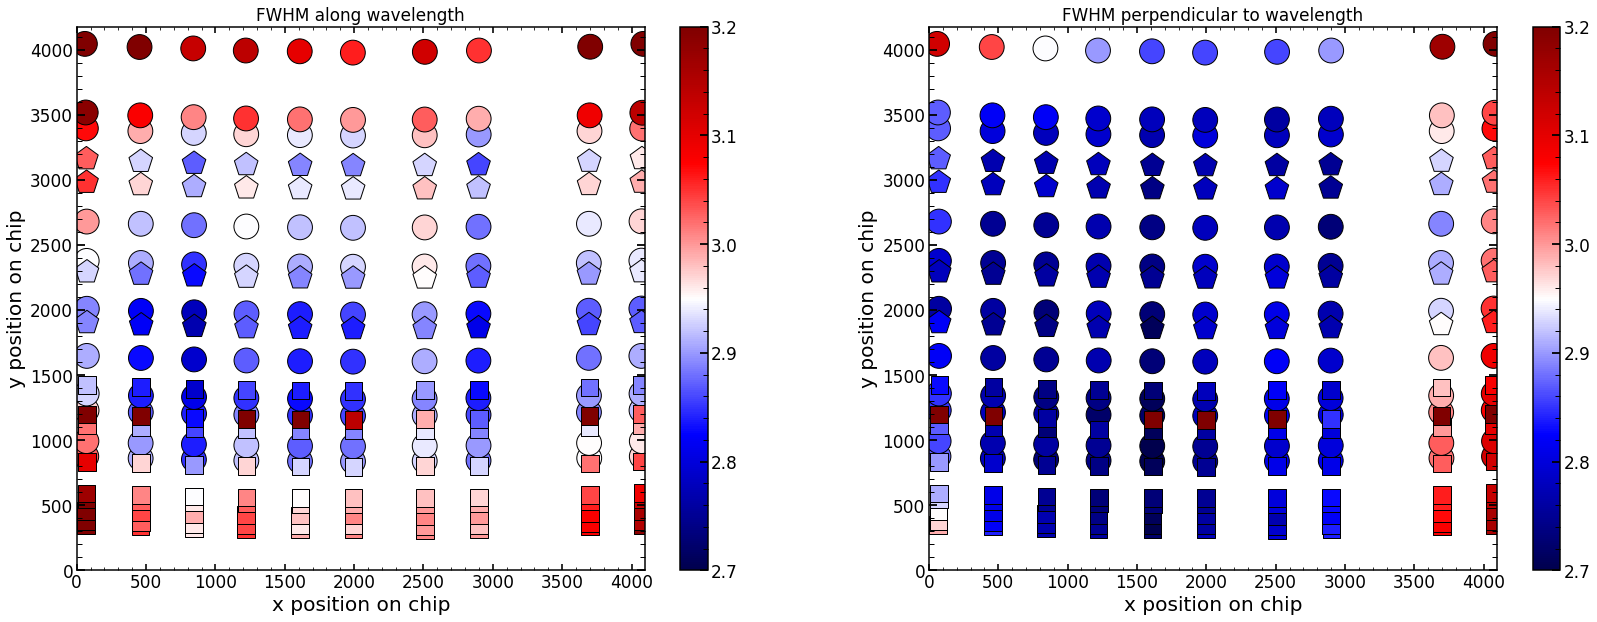

In [384]:
plt.figure(figsize=(28,10))

plt.subplot(121)
plt.scatter(x_Ar, y_Ar, s=np.pi * (14 * 1)**2, c=values_Ar_vw, cmap='seismic', alpha=1,vmin=2.7, vmax=3.2,edgecolor='black',marker='o')
plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_vw, cmap='seismic', alpha=1,vmin=2.7, vmax=3.2,edgecolor='black',marker='s')
plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_vw, cmap='seismic', alpha=1,vmin=2.7, vmax=3.2,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('FWHM along wavelength')
plt.colorbar()
plt.subplot(122)

plt.scatter(x_Ar_per_x, y_Ar_per_x, s=np.pi * (14 * 1)**2, c=values_Ar_per_x, cmap='seismic', alpha=1,vmin=2.7, vmax=3.2,edgecolor='black',marker='o')
plt.scatter(x_Ne_per_x, y_Ne_per_x, s=np.pi * (10 * 1)**2, c=values_Ne_per_x, cmap='seismic', alpha=1,vmin=2.7, vmax=3.2,edgecolor='black',marker='s')
plt.scatter(x_Kr_per_x, y_Kr_per_x, s=np.pi * (14 * 1)**2, c=values_Kr_per_x, cmap='seismic', alpha=1,vmin=2.7, vmax=3.2,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('FWHM perpendicular to wavelength')
plt.colorbar()

In [306]:
FWHM_per_spot_Ne

array([[ 0.  ,  2.99],
       [ 1.  ,  2.97],
       [ 2.  ,  2.95],
       [ 3.  ,  2.93],
       [ 4.  ,  2.91],
       [ 5.  ,  2.9 ],
       [ 6.  ,  2.87],
       [ 7.  ,  3.9 ],
       [ 8.  ,  2.83],
       [ 9.  ,  2.84],
       [10.  ,  2.82],
       [11.  ,  2.81],
       [12.  ,  2.81],
       [13.  ,  2.81],
       [14.  ,  2.79],
       [15.  ,  2.77],
       [16.  ,  3.24],
       [17.  ,  2.76],
       [18.  ,  2.77],
       [19.  ,  2.77],
       [20.  ,  2.77],
       [21.  ,  2.75],
       [22.  ,  2.75],
       [23.  ,  2.75],
       [24.  ,  2.73],
       [25.  ,  2.76],
       [26.  ,  2.74],
       [27.  ,  2.76],
       [28.  ,  2.75],
       [29.  ,  2.74],
       [30.  ,  2.73],
       [31.  ,  2.73],
       [32.  ,  2.74],
       [33.  ,  2.76],
       [35.  ,  2.75],
       [36.  ,  2.72],
       [37.  ,  2.7 ],
       [38.  ,  2.71],
       [39.  ,  2.73],
       [40.  ,  2.73],
       [41.  ,  2.71],
       [42.  ,  2.71],
       [43.  ,  3.53],
       [44.

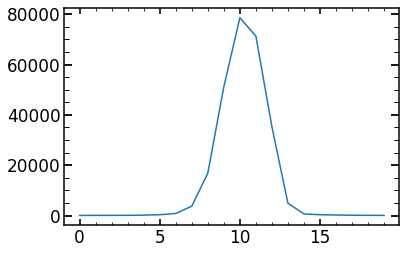

In [231]:
plt.plot(data)